# Install Libraries & Dependencies

In [1]:
pip install scikit-image

In [2]:
!pip install scikit-image --upgrade


In [3]:
import os
import numpy as np
import cv2
import glob
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
import tensorflow as tf
from tensorflow.keras import layers, models

In [5]:
import zipfile

zip_file_path = '/content/BraTs18.zip'
extract_path = '/content/BraTs18'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: /content/BraTs18


# Data Preprocessing

In [6]:
images_dir = "/content/BraTs18/brats18/images"
masks_dir = "/content/BraTs18/brats18/masks"

image_files = sorted(glob.glob(os.path.join(images_dir, "image_*.png")))
print(f"Found {len(image_files)} image files: {image_files}")

mask_files = sorted(glob.glob(os.path.join(masks_dir, "mask_*.png")))
print(f"Found {len(mask_files)} mask files: {mask_files}")

Found 5042 image files: ['/content/BraTs18/brats18/images/image_1.png', '/content/BraTs18/brats18/images/image_10.png', '/content/BraTs18/brats18/images/image_100.png', '/content/BraTs18/brats18/images/image_1000.png', '/content/BraTs18/brats18/images/image_1001.png', '/content/BraTs18/brats18/images/image_1002.png', '/content/BraTs18/brats18/images/image_1003.png', '/content/BraTs18/brats18/images/image_1004.png', '/content/BraTs18/brats18/images/image_1005.png', '/content/BraTs18/brats18/images/image_1006.png', '/content/BraTs18/brats18/images/image_1007.png', '/content/BraTs18/brats18/images/image_1008.png', '/content/BraTs18/brats18/images/image_1009.png', '/content/BraTs18/brats18/images/image_101.png', '/content/BraTs18/brats18/images/image_1010.png', '/content/BraTs18/brats18/images/image_1011.png', '/content/BraTs18/brats18/images/image_1012.png', '/content/BraTs18/brats18/images/image_1013.png', '/content/BraTs18/brats18/images/image_1014.png', '/content/BraTs18/brats18/images

In [7]:
assert len(image_files) == len(mask_files), "Mismatch between images and masks!"

In [8]:
# Function to load an image as grayscale
def load_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return image

In [9]:
# Function to normalize an image by scaling pixel values to the range [0, 1]
def normalize_image(image):
    image = image.astype(np.float32)
    return image / 255.0

In [10]:
# Function to apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance contrast
def enhance_contrast(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply((image * 255).astype(np.uint8)) / 255.0

In [11]:
# Function to resize an image to the target size (default 112x112)
def resize_image(image, target_size=(112, 112)):
    return cv2.resize(image, target_size)

In [12]:
# Function to preprocess the image by normalizing, enhancing contrast, and resizing
def preprocess_image(file_path, target_size=(112, 112)):
    image = load_image(file_path)
    normalized_image = normalize_image(image)
    enhanced_image = enhance_contrast(normalized_image)
    resized_image = resize_image(enhanced_image, target_size)
    return resized_image

In [13]:
# Shuffle and split the data into training and validation sets (80%/20%)
combined = list(zip(image_files, mask_files))
random.shuffle(combined)
split_idx = int(len(combined) * 0.8)
train_pairs = combined[:split_idx]
val_pairs = combined[split_idx:]

In [14]:
# Apply preprocessing to training and validation images
train_images = [preprocess_image(img_path) for img_path, _ in train_pairs]
train_masks = [load_image(mask_path) for _, mask_path in train_pairs]
val_images = [preprocess_image(img_path) for img_path, _ in val_pairs]
val_masks = [load_image(mask_path) for _, mask_path in val_pairs]

In [15]:
print(f"Sample preprocessed image shape: {train_images[0].shape}")
print(f"Sample mask shape: {train_masks[0].shape}")

Sample preprocessed image shape: (112, 112)
Sample mask shape: (240, 240)


# Exploratory Data Analysis (EDA)

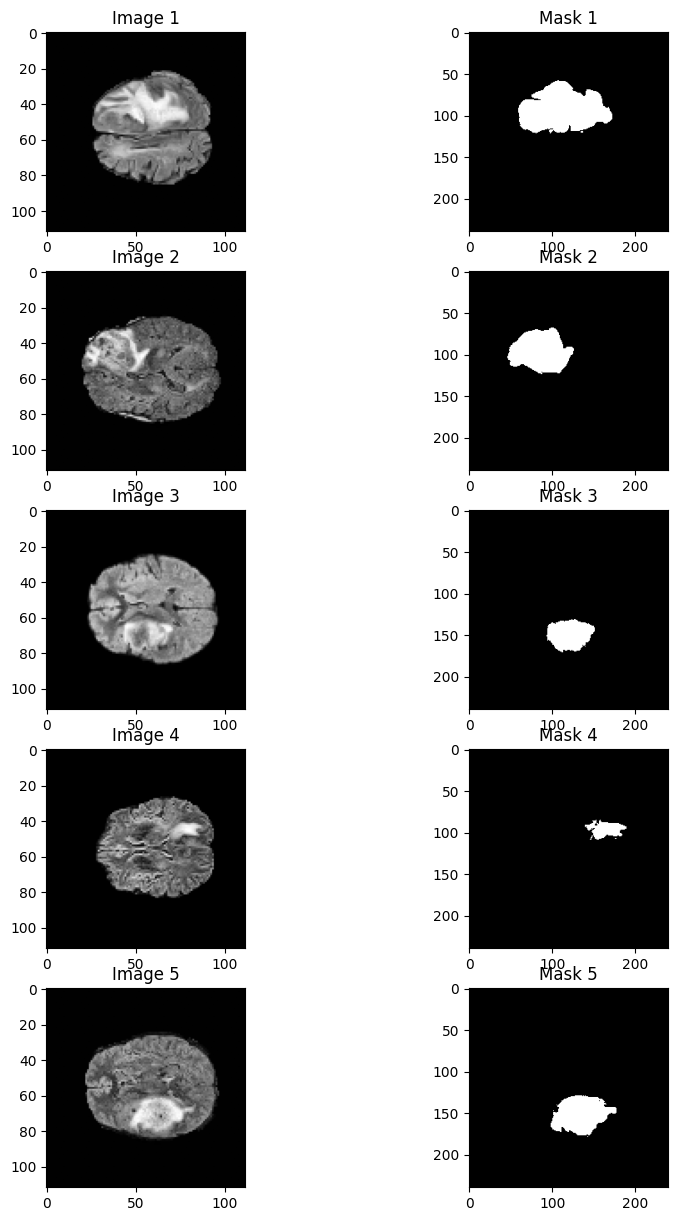

In [16]:
# Function to display sample images and their corresponding masks
def display_sample_images(images, masks, n_samples=5):
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 15))
    for i in range(n_samples):
        axes[i, 0].imshow(images[i], cmap='gray')
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title(f"Mask {i+1}")
    plt.show()

display_sample_images(train_images, train_masks)

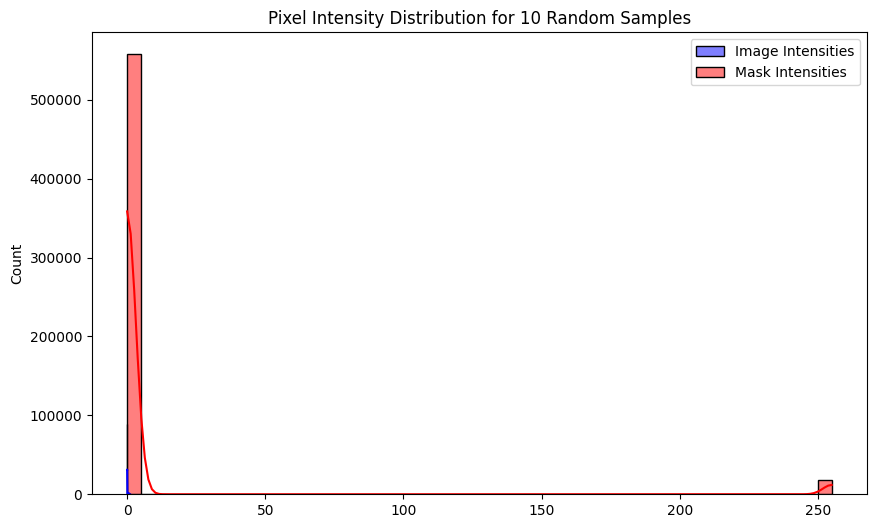

In [17]:
# Function to plot pixel intensity distribution for a small sample of images and masks
import random
def plot_pixel_intensity_histogram(images, masks, sample_size=10):
    sample_indices = random.sample(range(len(images)), sample_size)
    sample_images = [images[i] for i in sample_indices]
    sample_masks = [masks[i] for i in sample_indices]
    image_intensity = np.concatenate([img.flatten() for img in sample_images])
    mask_intensity = np.concatenate([mask.flatten() for mask in sample_masks])
    plt.figure(figsize=(10, 6))
    sns.histplot(image_intensity, bins=50, color='blue', label='Image Intensities', kde=True)
    sns.histplot(mask_intensity, bins=50, color='red', label='Mask Intensities', kde=True)
    plt.legend()
    plt.title(f'Pixel Intensity Distribution for {sample_size} Random Samples')
    plt.show()

plot_pixel_intensity_histogram(train_images, train_masks, sample_size=10)


# Feature Engineering

In [ ]:
# Function to extract texture features using Grey Level Co-occurrence Matrix (GLCM)
def extract_texture_features(image):
    image = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    correlation = graycoprops(glcm, 'correlation')
    energy = graycoprops(glcm, 'energy')
    homogeneity = graycoprops(glcm, 'homogeneity')
    return contrast[0, 0], correlation[0, 0], energy[0, 0], homogeneity[0, 0]

features = extract_texture_features(train_images[0])
print("Texture Features (Contrast, Correlation, Energy, Homogeneity):", features)

Texture Features (Contrast, Correlation, Energy, Homogeneity): (np.float64(241.22377734877733), np.float64(0.9616848781183702), np.float64(0.6925881811424732), np.float64(0.7129021436706336))


# 2D ResNet Model

In [ ]:
def build_resnet_model_v2(input_shape=(112, 112, 1), num_classes=5):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    def residual_block(x, filters, strides=(1, 1)):
        shortcut = x
        x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3, 3), strides=(1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        if strides != (1, 1) or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Add()([shortcut, x])
        x = layers.Activation('relu')(x)
        return x

    x = residual_block(x, 32)
    x = residual_block(x, 32)
    x = residual_block(x, 32)
    x = residual_block(x, 64, strides=(2, 2))
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, strides=(2, 2))
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 256, strides=(2, 2))
    x = residual_block(x, 256)
    x = residual_block(x, 256)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = build_resnet_model_v2(input_shape=(112, 112, 1), num_classes=5)
model.summary()
train_labels = np.array([np.argmax(np.bincount(mask.flatten())) for mask in train_masks])
val_labels = np.array([np.argmax(np.bincount(mask.flatten())) for mask in val_masks])
model.fit(
    np.array(train_images),
    train_labels,
    epochs=10,
    batch_size=16,
    validation_data=(np.array(val_images), val_labels)
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 56, 56,    │      1,600 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        128 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 28, 28,    │      9,248 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 28, 28,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 28, 28,    │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 28, 28,    │          0 │ add_12[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 28, 28,    │      9,248 │ activation_12[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 28, 28,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 28, 28,    │          0 │ activation_12[0]… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 28, 28,    │          0 │ add_13[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 28, 28,    │      9,248 │ activation_13[0]

 Total params: 4,408,005 (16.82 MB)

 Trainable params: 4,401,285 (16.79 MB)

 Non-trainable params: 6,720 (26.25 KB)

Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 255s 851ms/step - accuracy: 0.9759 - loss: 0.0814 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 255s 823ms/step - accuracy: 1.0000 - loss: 2.3917e-08 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 209s 828ms/step - accuracy: 1.0000 - loss: 1.6094e-08 - val_accuracy: 1.0000 - val_loss: 3.5444e-10
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 252s 791ms/step - accuracy: 1.0000 - loss: 2.7572e-09 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 202s 791ms/step - accuracy: 1.0000 - loss: 3.3491e-10 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 201s 788ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 212s 838ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
253/253 ━━━━━

## <h1><b>LIME</b></h1>


In [ ]:
np.array(val_images).shape

(1009, 112, 112)

In [ ]:
!pip install lime shap scikit-learn numpy pandas matplotlib tensorflow pillow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6db10d25587cfef70c446138c0afe475cd77362d7091cf70b131dd2e6e110164
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [27]:

x_train = np.array(train_images)
y_train = np.array([np.argmax(np.bincount(mask.flatten())) for mask in train_masks])
x_test = np.array(val_images)
y_test = np.array([np.argmax(np.bincount(mask.flatten())) for mask in val_masks])

In [ ]:
def get_examples_per_digit(x_test, y_test): # Added y_test as a parameter
    examples = {}
    for i in range(len(x_test)):
        true_label = np.argmax(y_test[i]) # Accessing y_test here
        if true_label not in examples:
            examples[true_label] = x_test[i]
        if len(examples) == 5:  # Updated condition to 5 as there are only 5 unique labels (0-4) in the dataset
            break
    return examples

digit_examples = get_examples_per_digit(x_test, y_test) # Calling with both arguments

In [ ]:
from skimage.segmentation import mark_boundaries

In [ ]:
from lime.lime_image import LimeImageExplainer # Import LimeImageExplainer

# ... (Your other code) ...

# Initialize the LimeImageExplainer
explainer = LimeImageExplainer() # Create a LimeImageExplainer object

# ... (Rest of your code using 'explainer') ...

In [ ]:
image = digit_examples[0]

In [ ]:
def model_predict(images):
    if images.ndim == 3:
        images = np.expand_dims(images, -1)
    if images.shape[-1] == 3:
        images = images.mean(axis=-1, keepdims=True)
    return model.predict(images, verbose=0)

In [ ]:
explanation = explainer.explain_instance(
    image.squeeze(),
    model_predict,
    top_labels=2,
    hide_color=0,
    num_samples=2000,
    batch_size=32,
    distance_metric='cosine'
)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
def model_predict(images):
    if images.ndim == 3:
        images = np.expand_dims(images, -1)
    if images.shape[-1] == 3:
        images = images.mean(axis=-1, keepdims=True)
    return model.predict(images, verbose=0)

In [ ]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # Use explanation.top_labels[0] to get the predicted class
    positive_only=False,
    num_features=10,
    hide_rest=False,
    min_weight=0.01
)

if np.all(mask == 0):
    mask = np.zeros_like(image.squeeze())
    for idx, weight in explanation.local_exp[explanation.top_labels[0]]:  # Use explanation.top_labels[0] here as well
        mask += weight * (explanation.segments == idx)
    mask = (mask != 0).astype(int)

  0%|          | 0/3000 [00:00<?, ?it/s]

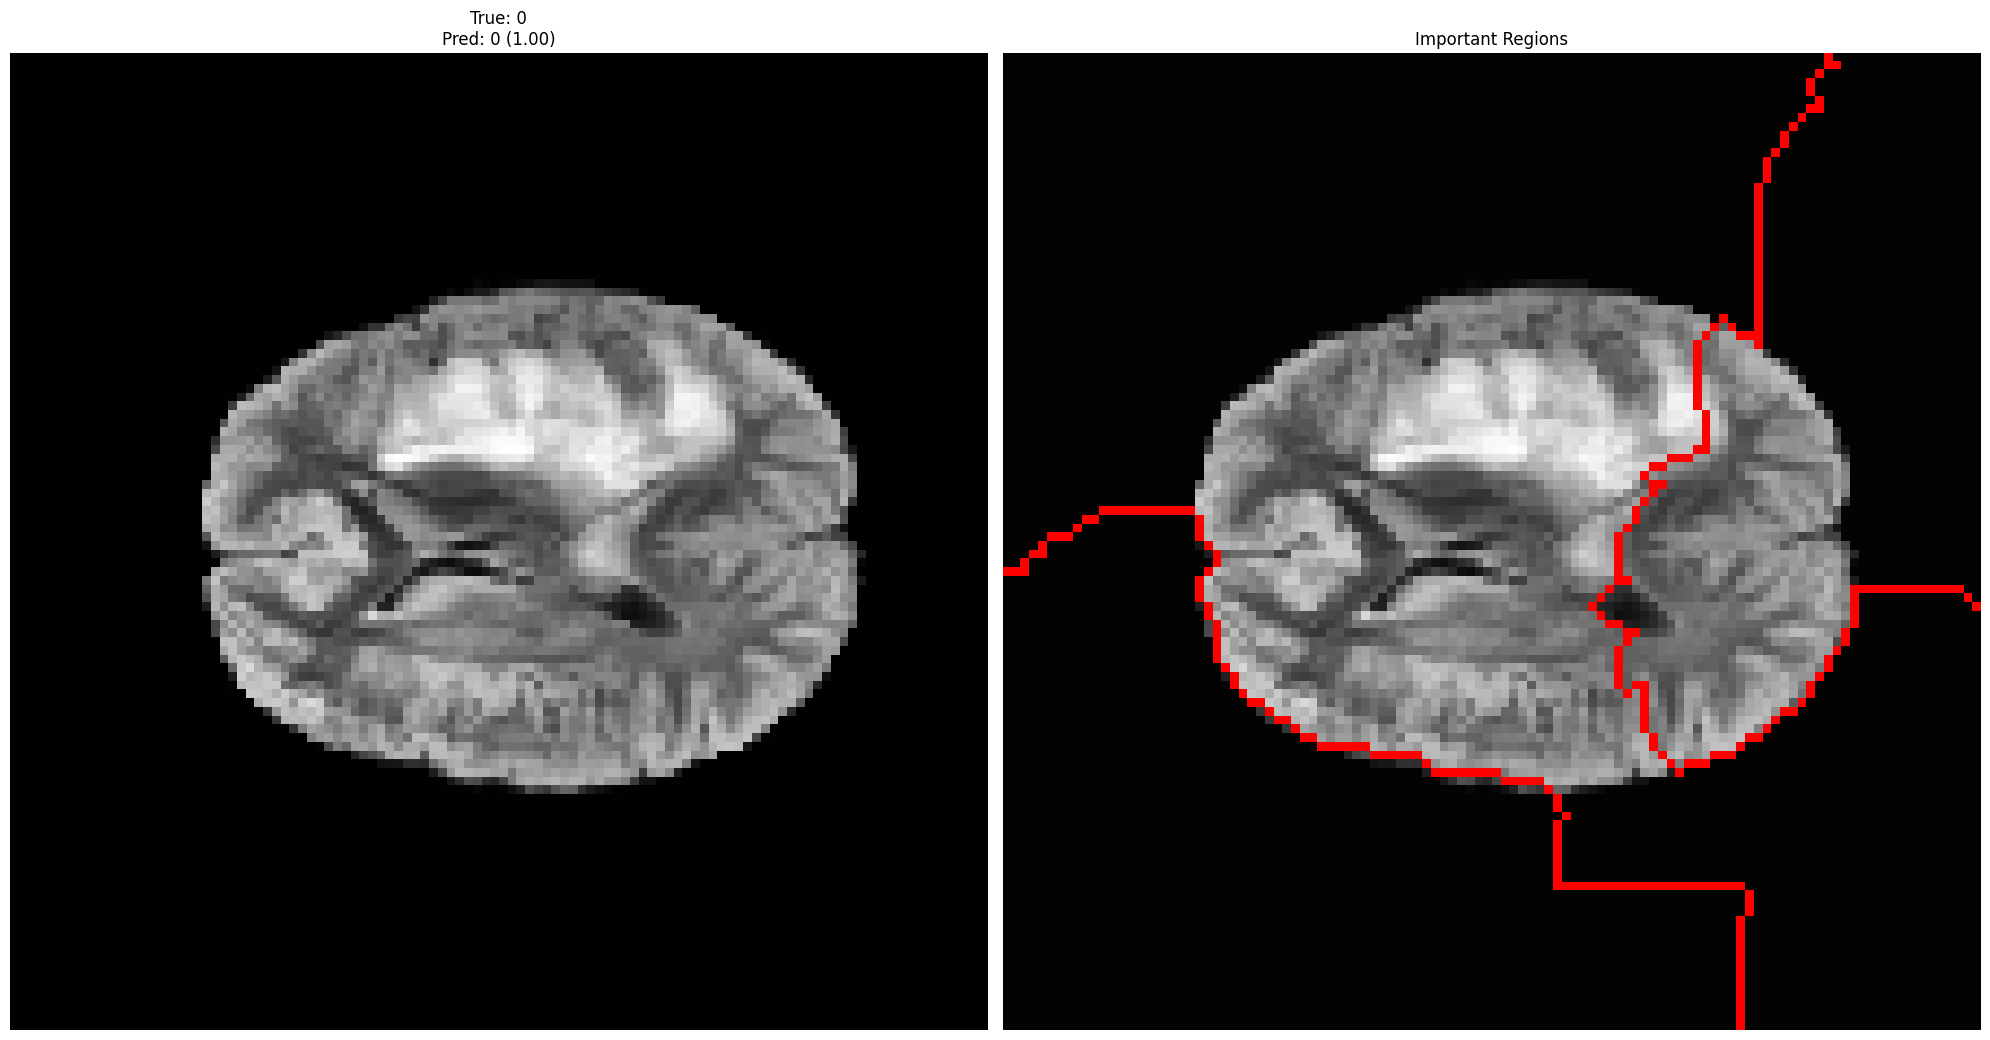

In [ ]:
plt.figure(figsize=(20, 25))

for idx, digit in enumerate(sorted(digit_examples.keys())):
    image = digit_examples[digit]

    # Remove the 'random_state' argument
    explanation = explainer.explain_instance(
        image.squeeze(),
        model_predict,
        top_labels=1,
        hide_color=0.5,
        num_samples=3000,
        # random_state=42  # Remove this line
    )

    pred = model_predict(image[np.newaxis, ...])
    pred_class = np.argmax(pred)
    pred_prob = np.max(pred)

    try:
        temp, mask = explanation.get_image_and_mask(
            pred_class,
            positive_only=True,
            num_features=15,
            hide_rest=False
        )

        if np.all(mask == 0):
            raise ValueError("Empty mask")

    except:
        mask = np.sum([np.abs(x[1]) * (explanation.segments == x[0])
                      for x in explanation.local_exp[pred_class]], axis=0)
        temp = image.squeeze()

    plt.subplot(len(digit_examples), 2, idx*2+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'True: {digit}\nPred: {pred_class} ({pred_prob:.2f})')
    plt.axis('off')

    plt.subplot(len(digit_examples), 2, idx*2+2)
    plt.imshow(mark_boundaries(
        temp/255. if temp.max() > 1 else temp,
        mask,
        color=(1,0,0),
        mode='inner'
    ))
    plt.title('Important Regions' if not np.all(mask==0) else 'No Important Regions Found')
    plt.axis('off')

plt.tight_layout()
plt.show()

# ***SHAP***

In [ ]:
# Find one clean example of each digit
digit_indices = {digit: None for digit in range(10)}
for i in range(len(x_test)):
    true_label = np.argmax(y_test[i])
    if digit_indices[true_label] is None:
        digit_indices[true_label] = i
    if all(v is not None for v in digit_indices.values()):
        break

In [ ]:
# Prepare data for SHAP
# Prepare data for SHAP
!pip install shap
import shap # Add this line to import the shap module

# Prepare data for SHAP
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
# Reshape background data to add channel dimension
background = background[..., np.newaxis]  # Add channel dimension

# Get the available keys in digit_examples
available_keys = list(digit_examples.keys())

# Use available keys to create test_images
# Add an extra dimension for the batch size to test_images
test_images = np.array([digit_examples[i] for i in available_keys])
test_images = test_images[..., np.newaxis] # Add a channel dimension to test_images
#test_images = np.expand_dims(test_images, axis=0)  # Remove this line to avoid adding an extra batch dimension

# Create SHAP explainer
explainer = shap.DeepExplainer(model, background)

# Get SHAP values
shap_values = explainer.shap_values(test_images)

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 112, 112, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 112, 112, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 112, 112,

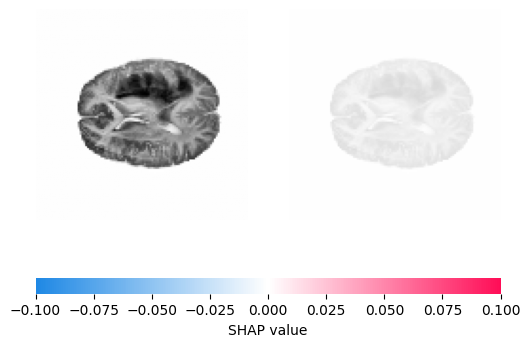

In [ ]:
shap.image_plot(shap_values, -test_images)

# **`*`Grad-CAM`*`**

In [ ]:
def compute_gradcam(model, img_tensor, class_idx):
    # Get the output of the last convolutional layer
    # Replace 'conv2d_55' with the actual name of the last convolutional layer in your model
    # You can find the layer names in the model summary (model.summary())
    grad_model = models.Model([model.inputs], [model.output, model.get_layer('conv2d_55').output])

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds, conv_outputs = grad_model(img_tensor)
        class_output = preds[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the Grad-CAM
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    cam = tf.maximum(cam, 0)
    cam = cam.numpy()
    cam = np.squeeze(cam)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    return cam


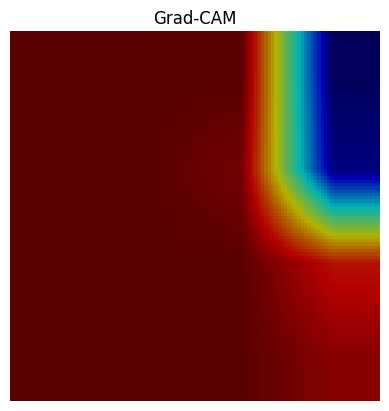

In [ ]:
img_tensor = np.expand_dims(np.array(train_images[0]), axis=0)  # Example image
img_tensor = tf.convert_to_tensor(img_tensor, dtype=tf.float32) # Convert img_tensor to a TensorFlow Tensor
class_idx = 0  # Example class index, you may change this

# Compute the Grad-CAM
cam = compute_gradcam(model, img_tensor, class_idx)

# Resize the Grad-CAM to match the input image size
cam = cv2.resize(cam, (112, 112))

# Convert to heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

# Prepare the image to overlay
np_img = np.array(train_images[0])  # Use the original image

# Overlay the heatmap on the image
# Overlay the heatmap on the image
overlay = 0.7 * heatmap[:, :, :3] + np.expand_dims(np_img, axis=-1)  # Add axis to np_img to make it 3D
plt.imshow(overlay.astype(np.uint8))
plt.title("Grad-CAM")
plt.axis("off")
plt.show()

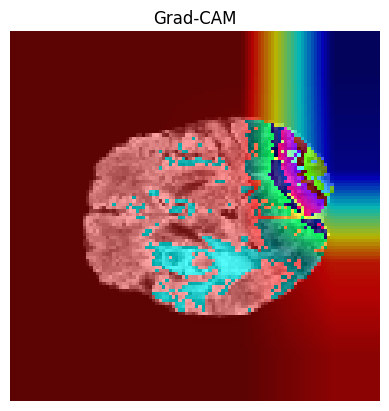

In [ ]:
# Resize the Grad-CAM to match the input image size
cam = cv2.resize(cam, (112, 112))  #

# Convert to heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

# Prepare the image to overlay
np_img = np.array(train_images[0])  #
# Overlay the heatmap on the image
# Add an extra dimension to np_img to make it compatible with heatmap
np_img = np.expand_dims(np_img, axis=-1)
overlay = 0.7 * heatmap + np_img * 255  #  and scale np_img to 0-255

plt.imshow(overlay.astype(np.uint8))  #
plt.title("Grad-CAM")  #
plt.axis("off")  #
plt.show()  # ع

# ***Google DeepDream***


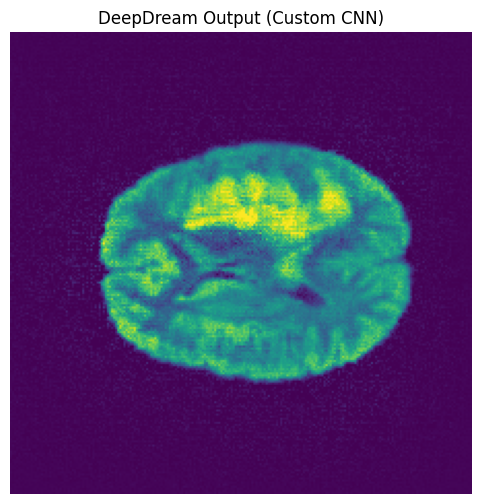

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# -------------------------------
# -------------------------------
dream_model = nn.Sequential(*list(model.children())[:6])  # Up to MaxPool2d (32 channels)
dream_model.eval()

# -------------------------------
# Preprocessing & Deprocessing
# -------------------------------
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def deprocess(tensor):
    # إزالة بُعد الـ batch لو موجود
    if tensor.dim() == 4:
        tensor = tensor.squeeze(0)

    if tensor.dim() == 3:
        img = tensor.permute(1, 2, 0).detach().cpu().numpy()
    elif tensor.dim() == 2:
        img = tensor.unsqueeze(0).permute(1, 2, 0).detach().cpu().numpy()
    else:
        raise ValueError(f"Unexpected tensor dimension: {tensor.dim()}")

    return np.clip(img, 0, 1)

# -------------------------------
# DeepDream Function
# -------------------------------
def deepdream(image, model, iterations=100, lr=0.001):
    image = image.clone().detach().requires_grad_(True)

    for i in range(iterations):
        model.zero_grad()
        out = model(image)
        loss = out.norm()
        loss.backward()
        image.data += lr * image.grad.data
        image.grad.data.zero_()
    return image.detach()

# -------------------------------
# Preprocess input image
# -------------------------------
image_np = digit_examples[0].squeeze()  # Assuming digit_examples[0] is a tensor
image_pil = Image.fromarray((image_np * 255).astype(np.uint8))  # Convert to PIL Image
input_tensor = preprocess(image_pil).unsqueeze(0)  # shape: (1, 3, 224, 224)

# -------------------------------
# Apply DeepDream
# -------------------------------
dreamed_tensor = deepdream(input_tensor, dream_model)

# -------------------------------
# Visualize and Save Output
# -------------------------------
output_image = deprocess(dreamed_tensor)

plt.figure(figsize=(8, 6))
plt.imshow(output_image)
plt.title("DeepDream Output (Custom CNN)")
plt.axis("off")
plt.show()

output_image_uint8 = (output_image * 255).astype(np.uint8)

if output_image_uint8.ndim == 3 and output_image_uint8.shape[2] == 1:
    output_image_uint8 = output_image_uint8.squeeze(2)

Image.fromarray(output_image_uint8).save("deepdream_result.png")
